## Recitation 11/02/2018

### Source
This notebook is an O'Reilly Tutorial on t-SNE which demonstrates the key mathematical assumptions of the algorithm.  We will walk through this tutorial, and watch parts of a Google Talk given by Laurens van der Maaten to reinforce our understanding of t-SNE.

Original OReilly Tutorial: https://github.com/oreillymedia/t-SNE-tutorial

Laurens van der Maaten's Video Tutorial on Large-Scale t-SNE: https://www.youtube.com/watch?v=RJVL80Gg3lA&list=UUtXKDgv1AVoG88PLl8nGXmw


## An Illustrated Introduction to the t-SNE Algorithm

In the Big Data era, data is not only becoming bigger and bigger; it is also becoming more and more complex. This translates into a spectacular increase of the dimensionality of the data. For example, the dimensionality of a set of images is the number of pixels in any image, which ranges from thousands to millions.

Computers have no problem processing that many dimensions. However, we humans are limited to three dimensions. Computers still need us (thankfully), so we often need ways to effectively visualize high-dimensional data before handing it over to the computer.

How can we possibly reduce the dimensionality of a dataset from an arbitrary number to two or three, which is what we're doing when we visualize data on a screen?

The answer lies in the observation that many real-world datasets have a low intrinsic dimensionality, even though they're embedded in a high-dimensional space. Imagine that you're shooting a panoramic landscape with your camera, while rotating around yourself. We can consider every picture as a point in a 16,000,000-dimensional space (assuming a 16 megapixels camera). Yet, the set of pictures approximately lie in a three-dimensional space (yaw, pitch, roll). This low-dimensional space is embedded within the high-dimensional space in a complex, nonlinear way. Hidden in the data, this structure can only be recovered via specific mathematical methods.

This is the topic of manifold learning, also called nonlinear dimensionality reduction, a branch of machine learning (more specifically, unsupervised learning). It is still an active area of research today to develop algorithms that can automatically recover a hidden structure in a high-dimensional dataset.

This post is an introduction to a popular dimensonality reduction algorithm: t-distributed stochastic neighbor embedding (t-SNE). Developed by Laurens van der Maaten and Geoffrey Hinton (see the original paper here), this algorithm has been successfully applied to many real-world datasets. Here, we'll follow the original paper and describe the key mathematical concepts of the method, when applied to a toy dataset (handwritten digits). We'll use Python and the scikit-learn library.

In [7]:
# That's an impressive list of imports.
import numpy as np
from numpy import linalg
from numpy.linalg import norm
from scipy.spatial.distance import squareform, pdist

# We import sklearn.
import sklearn
from sklearn.manifold import TSNE
from sklearn.datasets import load_digits
from sklearn.preprocessing import scale

# We'll hack a bit with the t-SNE code in sklearn 0.15.2.
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.manifold.t_sne import (_joint_probabilities,
                                    _kl_divergence)
#from sklearn.utils.extmath import _ravel
# Random state.
RS = 20150101

# We'll use matplotlib for graphics.
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import matplotlib
%matplotlib inline

# We import seaborn to make nice plots.
import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5,
                rc={"lines.linewidth": 2.5})

# We'll generate an animation with matplotlib and moviepy.
from moviepy.video.io.bindings import mplfig_to_npimage
import moviepy.editor as mpy
import PIL

In [8]:
#Load Digits Dataset
digits = load_digits()
digits.data.shape

(1797, 64)

In [9]:
# We first reorder the data points according to the handwritten numbers.
X = np.vstack([digits.data[digits.target==i]
               for i in range(10)])
y = np.hstack([digits.target[digits.target==i]
               for i in range(10)])

In [10]:
digits_proj = TSNE(random_state=RS).fit_transform(X)

(<matplotlib.figure.Figure at 0x14e58151e80>,
 [Text(35.1412,49.0518,'0'),
  Text(-1.20464,-15.7391,'1'),
  Text(-48.6733,-17.7098,'2'),
  Text(-38.29,20.2608,'3'),
  Text(33.918,-39.8033,'4'),
  Text(8.07994,21.03,'5'),
  Text(49.5953,2.4024,'6'),
  Text(-5.96337,-48.3856,'7'),
  Text(-15.3029,-1.47993,'8'),
  Text(-15.0129,33.071,'9')])

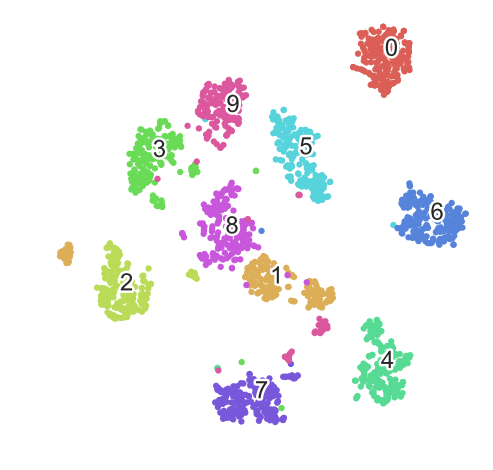

In [11]:
def scatter(x, colors):
    # We choose a color palette with seaborn.
    palette = np.array(sns.color_palette("hls", 10))

    # We create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40,
                    c=palette[colors.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    # We add the labels for each digit.
    txts = []
    for i in range(10):
        # Position of each label.
        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)

    return f, ax, sc, txts

scatter(digits_proj, y)

## Mathematical Framework

Let's explain how the algorithm works. First, a few definitions.

A data point is a point $x_i$ in the original data space $\mathbf{R}^D$, where $D=64$ is the dimensionality of the data space. Every point is an image of a handwritten digit here. There are $N=1797$ points.

A map point is a point $y_i$ in the map space $\mathbf{R}^2$. This space will contain our final representation of the dataset. There is a bijection between the data points and the map points: every map point represents one of the original images.

How do we choose the positions of the map points? We want to conserve the structure of the data. More specifically, if two data points are close together, we want the two corresponding map points to be close too. Let's $\left| x_i - x_j \right|$ be the Euclidean distance between two data points, and $\left| y_i - y_j \right|$ the distance between the map points. We first define a conditional similarity between the two data points:

$p_{j|i} = \frac{\exp\left(-\left| x_i - x_j\right|^2 \big/ 2\sigma_i^2\right)}{\displaystyle\sum_{k \neq i} \exp\left(-\left| x_i - x_k\right|^2 \big/ 2\sigma_i^2\right)}$

This measures how close $x_j$ is from $x_i$, considering a Gaussian distribution around $x_i$ with a given variance $\sigma_i^2$. This variance is different for every point; it is chosen such that points in dense areas are given a smaller variance than points in sparse areas. The original paper details how this variance is computed exactly.

Now, we define the similarity as a symmetrized version of the conditional similarity:

$p_{ij} = \frac{p_{j|i} + p_{i|j}}{2N}$

We obtain a similarity matrix for our original dataset. What does this matrix look like?

### Similarity Matrix

The following function computes the similarity with a constant $sigma$.

In [12]:
def _joint_probabilities_constant_sigma(D, sigma):
    P = np.exp(-D**2/2 * sigma**2)
    P /= np.sum(P, axis=1)
    return P

We now compute the similarity with a $sigma_i$ depending on the data point (found via a binary search, according to the original t-SNE paper). This algorithm is implemented in the _joint_probabilities private function in scikit-learn's code.

In [13]:
# Pairwise distances between all data points.
D = pairwise_distances(X, squared=True)
# Similarity with constant sigma.
P_constant = _joint_probabilities_constant_sigma(D, .002)
# Similarity with variable sigma.
P_binary = _joint_probabilities(D, 30., False)
# The output of this function needs to be reshaped to a square matrix.
P_binary_s = squareform(P_binary)

We can now display the distance matrix of the data points, and the similarity matrix with both a constant and variable sigma.

Text(0.5,1,'$p_{j|i}$ (variable $\\sigma$)')

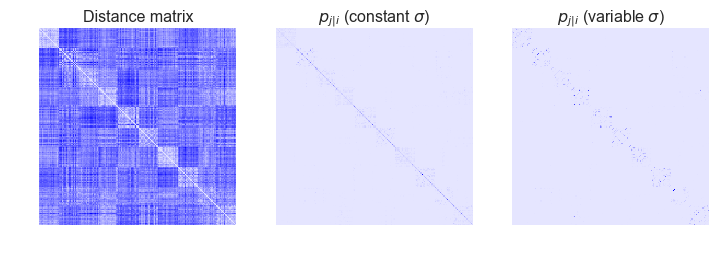

In [14]:
plt.figure(figsize=(12, 4))
pal = sns.light_palette("blue", as_cmap=True)

plt.subplot(131)
plt.imshow(D[::10, ::10], interpolation='none', cmap=pal)
plt.axis('off')
plt.title("Distance matrix", fontdict={'fontsize': 16})

plt.subplot(132)
plt.imshow(P_constant[::10, ::10], interpolation='none', cmap=pal)
plt.axis('off')
plt.title("$p_{j|i}$ (constant $\sigma$)", fontdict={'fontsize': 16})

plt.subplot(133)
plt.imshow(P_binary_s[::10, ::10], interpolation='none', cmap=pal)
plt.axis('off')
plt.title("$p_{j|i}$ (variable $\sigma$)", fontdict={'fontsize': 16})

We can already observe the 10 groups in the data, corresponding to the 10 numbers.

Let's also define a similarity matrix for our map points.

$q_{ij} = \frac{f(\left| x_i - x_j\right|)}{\displaystyle\sum_{k \neq i} f(\left| x_i - x_k\right|)} \quad \textrm{with} \quad f(z) = \frac{1}{1+z^2}$

This is the same idea as for the data points, but with a different distribution (t-Student with one degree of freedom, or Cauchy distribution, instead of a Gaussian distribution). We'll elaborate on this choice later.

Whereas the data similarity matrix $\big(p_{ij}\big)$ is fixed, the map similarity matrix $\big(q_{ij}\big)$ depends on the map points. What we want is for these two matrices to be as close as possible. This would mean that similar data points yield similar map points.

### A physical analogy

Let's assume that our map points are all connected with springs. The stiffness of a spring connecting points $i$ and $j$ depends on the mismatch between the similarity of the two data points and the similarity of the two map points, that is, $p_{ij} - q_{ij}$. Now, we let the system evolve according to the laws of physics. If two map points are far apart while the data points are close, they are attracted together. If they are nearby while the data points are dissimilar, they are repelled.

The final mapping is obtained when the equilibrium is reached.

Here is an illustration of a dynamic graph layout based on a similar idea. Nodes are connected via springs and the system evolves according to law of physics (example by Mike Bostock).

### Algorithm

Remarkably, this physical analogy stems naturally from the mathematical algorithm. It corresponds to minimizing the Kullback-Leiber divergence between the two distributions $\big(p_{ij}\big)$ and $\big(q_{ij}\big)$:

$KL(P||Q) = \sum_{i, j} p_{ij} , \log \frac{p_{ij}}{q_{ij}}.$

This measures the distance between our two similarity matrices.

To minimize this score, we can use a method called gradient descent--at this point in 95-865, you do *not* need to know gradient descent. We will cover gradient descent toward the end of the course.

### The Student t-Distribution

Let's now explain the choice of the t-Student distribution for the map points, while a normal distribution is used for the data points. It is well known that the volume of the $N$-dimensional ball of radius $r$ scales as $r^N$. When $N$ is large, if we pick random points uniformly in the ball, most points will be close to the surface, and very few will be near the center.

This is illustrated by the following simulation, showing the distribution of the distances of these points, for different dimensions.

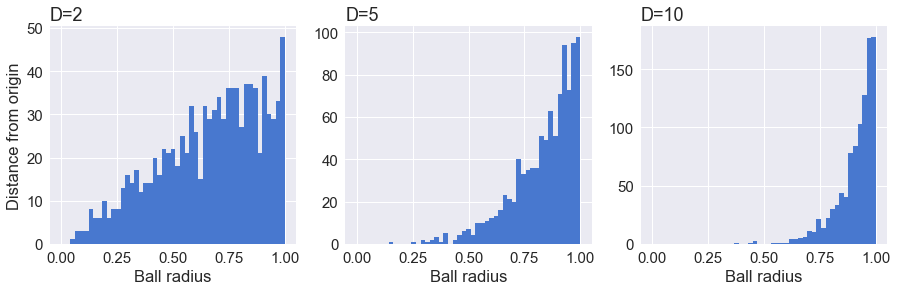

In [21]:
npoints = 1000
plt.figure(figsize=(15, 4))
for i, D in enumerate((2, 5, 10)):
    # Normally distributed points.
    u = np.random.randn(npoints, D)
    # Now on the sphere.
    u /= norm(u, axis=1)[:, None]
    # Uniform radius.
    r = np.random.rand(npoints, 1)
    # Uniformly within the ball.
    points = u * r**(1./D)
    # Plot.
    ax = plt.subplot(1, 3, i+1)
    ax.set_xlabel('Ball radius')
    if i == 0:
        ax.set_ylabel('Distance from origin')
    ax.hist(norm(points, axis=1),
            bins=np.linspace(0., 1., 50))
    ax.set_title('D=%d' % D, loc='left')
#plt.savefig('images/spheres-generated.png', dpi=100, bbox_inches='tight')

When reducing the dimensionality of a dataset, if we used the same Gaussian distribution for the data points and the map points, we would get an imbalance in the distribution of the distances of a point's neighbors. This is because the distribution of the distances is so different between a high-dimensional space and a low-dimensional space. Yet, the algorithm tries to reproduce the same distances in the two spaces. This imbalance would lead to an excess of attraction forces and a sometimes unappealing mapping. This is actually what happens in the original SNE algorithm, by Hinton and Roweis (2002).

The t-SNE algorithm works around this problem by using a t-Student with one degree of freedom (or Cauchy) distribution for the map points. This distribution has a much heavier tail than the Gaussian distribution, which compensates the original imbalance. For a given similarity between two data points, the two corresponding map points will need to be much further apart in order for their similarity to match the data similarity. This can be seen in the following plot.

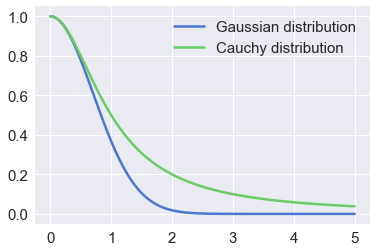

In [22]:
z = np.linspace(0., 5., 1000)
gauss = np.exp(-z**2)
cauchy = 1/(1+z**2)
plt.plot(z, gauss, label='Gaussian distribution')
plt.plot(z, cauchy, label='Cauchy distribution')
plt.legend()
#plt.savefig('images/distributions-generated.png', dpi=100)

The t-SNE algorithm provides an effective method to visualize a complex dataset. It successfully uncovers hidden structures in the data, exposing natural clusters and smooth nonlinear variations along the dimensions. It has been implemented in many languages, including Python, and it can be easily used thanks to the scikit-learn library.

The references below describe some optimizations and improvements that can be made to the algorithm and implementations. In particular, the algorithm described here is quadratic in the number of samples, which makes it unscalable to large datasets. One could for example obtain an $O(N \log N)$ complexity by using the Barnes-Hut algorithm to accelerate the N-body simulation via a quadtree or an octree.